In [21]:
# Standard Imports
import os
import sys
import warnings
sys.path.append("scripts")
warnings.filterwarnings("ignore")

# Relative Imports
from scripts import *

The input sound is initially binaural, thus keeping both channels to be able to play it.

In [22]:
file_name = "C dur rychle.wav"
base_name, extension = file_name.split(".")
sound = load_sound(file_name, monaural=False)

Loaded sound "..\data\wav\C dur rychle.wav"
Duration: 6.18666667 s, samples: 296960, samplerate: 48. kHz


If Pygame is installed, you can uncomment the line below to play the **input** sound.

<div class="alert alert-block alert-warning">Warning: the sound may be very loud.</div>

In [23]:
# sound.play(sleep=True)

For the rest of the implementation, monaural sound is needed. Here, only the left channel is used.

In [24]:
sound = sound.left

Next, for demonstration purposes, white noise is added to the input sound.

In [25]:
noise_level = 0.01
sound = add_white_noise(sound, noise_level)
save_sound(sound, base_name + " Noised." + extension)

If Pygame is installed, you can uncomment the line below to play the **noised** sound.

<div class="alert alert-block alert-warning">Warning: the sound may be very loud.</div>

In [26]:
# sound.play(sleep=True)

As a next step, a **cochleagram** is computed.

In [27]:
n_channels = 128
cochleagram, center_freqs = compute_cochleagram(sound, n_channels, return_cf=True)
print(f"Cochleagram shape: {cochleagram.shape}")

Cochleagram shape: (128, 296960)


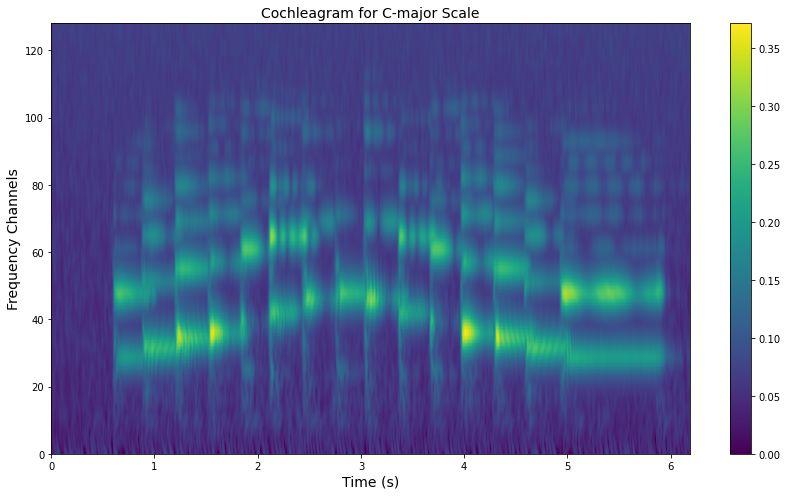

In [28]:
plot_cochleagram(cochleagram, sound.samplerate, figtitle="Cochleagram for C-major Scale",
                 save_figure=False, save_file_path=os.path.join("..", "text", "src", "include", "cochleagram_example_C-major.jpg"))

Then, the cochleagram is split into windows. Here, a rectangular window of size 20 ms is used, with an overlap of 10 ms.

In [29]:
print(f"Applying windowing to {sound.nsamples} samples:\n")

windows = apply_windowing(cochleagram, sound.samplerate)

print(f"Size: {WINDOW_SIZE_MS} ({windows.shape[2]} samples), "
      f"window shape: {windows.shape[1:]}\n"
      f"Overlap: {WINDOW_OVERLAP_MS} ({int(WINDOW_OVERLAP_MS * sound.samplerate)} samples)\n"
      f"Shape of the result: {windows.shape}")

Applying windowing to 296960 samples:

Size: 20. ms (960 samples), window shape: (128, 960)
Overlap: 10. ms (480 samples)
Shape of the result: (617, 128, 960)


For the feature extraction stage, a **correlogram**, **cross-channel correlation** and **summary ACF** are computed.

In [30]:
# Correlogram (ACF)
correlogram = compute_correlogram(windows)
print(f"Correlogram shape: {correlogram.shape}")

# Cross-channel correlation coefficients (Pearson's)
cccf = compute_cccf(windows)
print(f"Cross-channel correlation shape: {cccf.shape}")

# Summary ACF
sacf = compute_sacf(correlogram)
print(f"Summary autocorrelation shape: {sacf.shape}")

Correlogram shape: (617, 128, 960)
Cross-channel correlation shape: (617, 128)
Summary autocorrelation shape: (617, 960)


Next, **fundamental frequencies** and their **harmonics** are estimated as the ones having the maximum sum of SACF values.

In [31]:
n_harmonics = 5
fundamental_lags, fundamental_freqs = find_fundamental_frequencies(sacf, sound.samplerate, n_harmonics)
print(f"Fundamental lags shape: {fundamental_lags.shape}")
print(f"Fundamental frequencies shape: {fundamental_freqs.shape}")

Fundamental lags shape: (617,)
Fundamental frequencies shape: (617,)


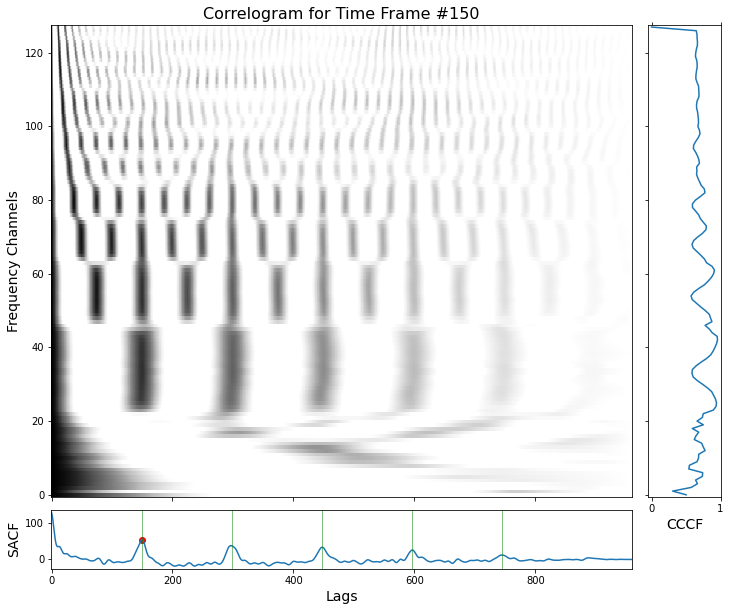

In [32]:
window_num = 150
plot_correlogram(correlogram, window_num, sound.samplerate, cccf=cccf, sacf=sacf,
                 show_f0=True, show_harmonics=True, n_harmonics=n_harmonics,
                 save_figure=False, save_file_path=os.path.join("..", "text", "src", "include", "correlogram_example.jpg"))

<div class="alert alert-block alert-info">Bonus: Experiments with segmentation.</div>

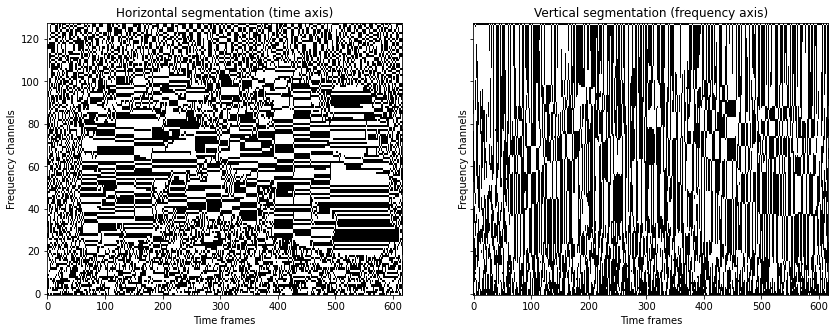

In [33]:
twcf_threshold = 0.8
cccf_threshold = 0.8
plot_segmentation(correlogram, twcf_threshold, cccf_threshold)

Finally, an **ideal binary mask** can be estimated...

In [34]:
energy_threshold = 0.05
agreement_threshold = 0.7

ibm, energy_values, agreement_ratios = compute_ibm(windows, fundamental_lags, sound.samplerate,
                                                   energy_threshold, agreement_threshold,
                                                   correlogram=correlogram, return_components=True)
print(f"IBM shape: {ibm.shape}")

IBM shape: (617, 128)


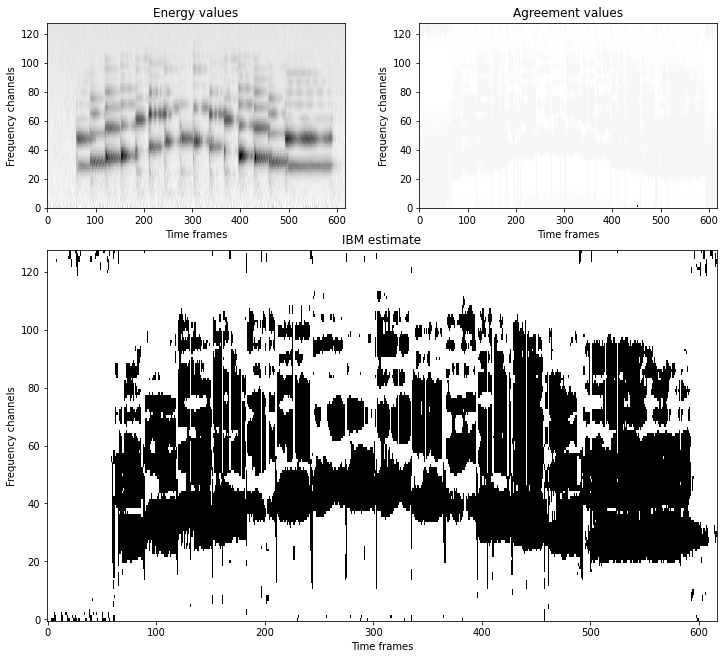

In [35]:
plot_ibm(ibm, energy_values, agreement_ratios,
         save_figure=False, save_file_path=os.path.join("..", "text", "src", "include", "ibm_example.jpg"))

... and the cochleagram can be masked.

In [36]:
masked_cochleagram = apply_mask(cochleagram, ibm, sound.samplerate)
print(f"Masked cochleagram shape: {masked_cochleagram.shape}")

Masked cochleagram shape: (128, 296960)


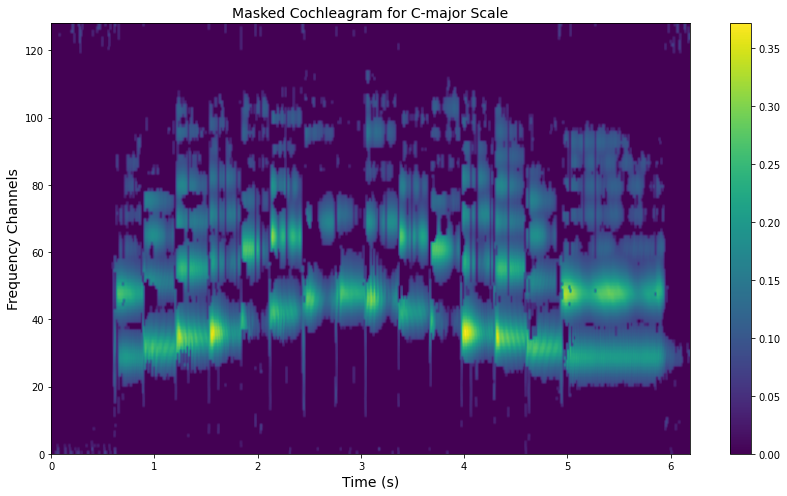

In [37]:
plot_cochleagram(masked_cochleagram, sound.samplerate, figtitle="Masked Cochleagram for C-major Scale",
         save_figure=False, save_file_path=os.path.join("..", "text", "src", "include", "masked_cochleagram_example.jpg"))

<div class="alert alert-block alert-info">Bonus: Resynthesis.</div>

In [38]:
resynth = resynthesize_sound(masked_cochleagram, sound.samplerate)
save_sound(resynth, base_name + " Resynth." + extension)

To be able to play the resynthesized sound, second channel is needed.

In [39]:
resynth = convert_to_binaural(resynth)

If Pygame is installed, you can uncomment the line below to play the **resynthesized** sound, however the quality of resynthesis is very low, because the algorithm is quite primitive.

<div class="alert alert-block alert-warning">Warning: the sound may be very loud.</div>

In [40]:
# resynth.play()